In [147]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import re
import os
import googlemaps
import requests
from geopy.distance import geodesic
from dotenv import load_dotenv
load_dotenv()

True

In [123]:
DISTANCE_THRESHOLD = 200

# Importing Sacramento County traffic fatalities data from ArcGIS

In [104]:
data_path = '../data/Motor_Vehicle_Accident_Deaths.csv'
df = pd.read_csv(data_path)
df.sample(10)

,OBJECTID,CaseNum,DecedentAge,Mode,SubManner,Gender,Race,DeathDate,DeathYear,IncidentPlace,IncidentAddress,Incident_Zip,Zip_Qty,IncidentDate,Cause,MaritalStatus,Homeless,Shape__Area,Shape__Length
699,700,22-01303,35,Driver,Accident (MVA),Male,Mexican,2/17/2022 12:00:00 AM,2022,Motor Vehicle,"Along Twin Cities Road, Ione, Amador, CA, 95640",95640.0,3.0,10/05/2003,"Sepsis with Pneumonia, Decubitus Ulcers, Parap...",Divorced,Y,1.594541e+07,21688.204885
724,725,22-02309,63,Motorcyclist,Accident (MVA),Male,African American,4/3/2022 12:00:00 AM,2022,Roadway/Highway,"Sheldon Road and Whitehouse Road, Elk Grove, S...",95758.0,26.0,04/02/2022,Blunt Force Injuries,Divorced,NaN,7.579864e+08,264781.252038
345,346,20-05513,28,Pedestrian,Accident (MVA),Female,White,9/30/2020 12:00:00 AM,2020,Roadway/Highway,"WB Florin Rd W of Power Inn Rd, Sacramento, Sa...",95828.0,39.0,09/29/2020,Multiple blunt force injuries,Never Married,Y,3.339616e+08,126209.619855
1012,1013,23-02919,26,Passenger,Accident (MVA),Female,White,6/8/2023 12:00:00 AM,2023,Roadway/Highway,"Folsom Blvd and Mills Park Drive, Rancho Cordo...",95670.0,30.0,06/01/2023,Blunt Force Injuries,Never Married,NaN,3.777880e+08,160392.814088
184,185,19-05785,41,Pedestrian,Accident (MVA),Female,Mexican,11/22/2019 12:00:00 AM,2019,Roadway/Highway,"Roseville Road, 15 feet north of Tacomic Dr., ...",95842.0,29.0,11/21/2019,Multiple blunt force injuries,Unknown,Y,1.145013e+08,71536.306284
914,915,22-07503,6,Passenger,Accident (MVA-Criminal),Male,Mexican,12/28/2022 12:00:00 AM,2022,Motor Vehicle - Moving,"Northbound SR-99, north of Harney Lane, Lodi, ...",95240.0,1.0,12/27/2022,Multiple Blunt Force Injuries,Never Married,NaN,NaN,NaN
590,591,21-06488,31,Driver,Accident (MVA),Female,White,9/28/2021 12:00:00 AM,2021,Motor Vehicle,"Fair Oaks Blvd 18 Ft. E of Marshall Ave, Carmi...",95608.0,26.0,09/27/2021,Blunt Force Injuries,Never Married,NaN,3.677188e+08,133389.199512
502,503,21-03287,54,Pedestrian,Accident (MVA),Female,"White, Mexican",5/7/2021 12:00:00 AM,2021,Roadway/Highway,I80 E/B 2595 ft East of SR-244 on ramp SR-51 S...,95841.0,20.0,05/06/2021,Multiple blunt force injuries,Married,Y,1.135221e+08,70041.845466
1091,1092,23-04820,46,Bicyclist,Accident (MVA),Male,White,9/30/2023 12:00:00 AM,2023,Roadway/Highway,Southbound Sylvan Road North of Greenback Lane...,95621.0,19.0,09/29/2023,Blunt Force Injuries,Never Married,Y,1.798810e+08,88507.791572
516,517,21-03760,26,Driver,Accident (MVA-Criminal),Male,"White, Hispanic",6/1/2021 12:00:00 AM,2021,Roadway/Highway,"County Rd 99 at Barnard St, Woodland, Yolo, CA...",95695.0,5.0,05/28/2021,Complications of multiple blunt force injuries,Never Married,NaN,NaN,NaN


In [105]:
df.count()

OBJECTID           1267
CaseNum            1267
DecedentAge        1264
Mode               1267
SubManner          1267
Gender             1267
Race               1265
DeathDate          1267
DeathYear          1267
IncidentPlace      1266
IncidentAddress    1253
Incident_Zip       1253
Zip_Qty            1253
IncidentDate       1250
Cause              1264
MaritalStatus      1262
Homeless            142
Shape__Area        1114
Shape__Length      1114
dtype: int64

In [106]:
df['IncidentPlace'].value_counts()

Roadway/Highway             859
Motor Vehicle               223
Motor Vehicle - Moving       96
Outdoors                     44
Parking Lot                  13
Unknown                       8
Sidewalk                      7
Residence - Own               5
Railroad - Tracks             2
North of Roadway              1
North Ridge Country Club      1
PARKING LOT                   1
Field                         1
SIDEWALK                      1
 Motor Vehicle - Moving       1
Extra Space Storage           1
Galt Mini Storage             1
Building                      1
Name: IncidentPlace, dtype: int64

In [107]:
def get_county_name(address):
    match = re.search(r'(?<=, )[A-z\s]+(?=, CA, [0-9]{5}$)', address)
    if match:
        return match.group(0)

df['County'] = df['IncidentAddress'].apply(lambda x: get_county_name(str(x)))

In [108]:
df['County'].value_counts()

Sacramento      1100
Yolo              40
El Dorado         14
Amador            12
Solano            11
Sutter            10
San Joaquin       10
Butte              9
Yuba               8
Placer             5
Contra Costa       3
Alameda            2
Colusa             2
Humboldt           2
Calaveras          2
Stanislaus         2
Nevada             2
Tuolumne           2
Merced             2
Siskiyou           2
Inyo               1
Plumas             1
Sierra             1
Modoc              1
Tehama             1
Santa Clara        1
Lake               1
Napa               1
Sonoma             1
Glenn              1
Name: County, dtype: int64

In [109]:
df = df.loc[df['County'] == 'Sacramento']

In [110]:
def get_city_name(address):
    match = re.search(r'(?<=, )[A-z\s]+(?=, Sacramento, CA, [0-9]{5}$)', address)
    if match:
        return match.group(0)

df['City'] = df['IncidentAddress'].apply(lambda x: get_city_name(str(x)))

In [111]:
df['City'].value_counts()

Sacramento         667
Elk Grove           74
North Highlands     42
Rancho Cordova      41
Folsom              32
Antelope            28
Citrus Heights      27
Galt                27
Carmichael          26
Fair Oaks           23
Rio Linda           22
Isleton             17
Orangevale          15
Walnut Grove        10
Elverta              8
Sloughhouse          8
Rio Vista            7
Wilton               6
Herald               5
Rancho Murieta       5
Rural Emmaton        3
Courtland            3
McClellan            2
Gold River           1
Rural Isleton        1
Name: City, dtype: int64

In [112]:
def clean_address(address):
    if address:
        return re.sub(r', [A-z\s,]+, Sacramento, CA, [0-9]{5}$', '', address).lower().strip()
    
df['CleanAddress'] = df['IncidentAddress'].apply(lambda x: clean_address(str(x)))

In [113]:
df['CleanAddress'].sample(10)

1047                       199 blue ravine road
1198               watt ave. and el camino ave.
1252                        7879 van vleck road
262             fruitridge rd at mendocino blvd
514     roseville rd. south of tri stations rd.
801                    sb sr51 n of marconi ave
526       half a mile west of michigan bar road
1137         15th ave, 50 feet west of 60th st.
447             rio linda blvd and south avenue
892                 nb i5 & laguna blvd offramp
Name: CleanAddress, dtype: object

In [114]:
direction_patterns = [
    r'\b(north|east|south|west)bound\b', r'\b[nesw]/?b\b'
]

def remove_direction_of_travel(address, direction_patterns):
    for pattern in direction_patterns:
        address = re.sub(pattern, '', address)
    return address.strip()

df['CleanAddress'] = df['CleanAddress'].apply(lambda x: remove_direction_of_travel(str(x), direction_patterns))

In [115]:
df['CleanAddress'].sample(10)

5             intersection of madison ave and date ave
182               i-5  1965 ft south of elk grove blvd
866                             3110 center court lane
779                        i-80 at longview dr offramp
939                                             ca-160
521             arden way , 226 ft east of howe avenue
677     intersection of gerber road and power inn road
94                  el camino avenue at parkwood drive
214           highway 99  2036 ft south of laguna blvd
1125                                  8144 pocket road
Name: CleanAddress, dtype: object

In [116]:
highway_patterns = [
    r'^s/?r[ \-]?[0-9]{1,3}', r'^i-?[580]{1,2}', r'^(us )?(hwy|highway) [0-9]{2,3}', r'^(us|ca)[\s\-][0-9]{2}',
    r'^interstate [0-9]{1,2}'
]

def detect_highway(address, highway_patterns):
    return any(re.search(pattern, address) for pattern in highway_patterns)

df['IsHighway'] = df['CleanAddress'].apply(lambda x: detect_highway(str(x), highway_patterns))

In [117]:
df.loc[~df['IsHighway'],'CleanAddress'].sample(10)

1103                                     mack road
298                   stockton blvd and lindale dr
937                          3035 mills park drive
1065                               north bound i-5
141     6724 6th street 188 feet south of m street
57       florin road, 37 feet west of edith street
1019              walerga rd. north of elverta rd.
614                     watt ave at don julio blvd
508                 south watt ave  at canberra dr
1137            15th ave, 50 feet west of 60th st.
Name: CleanAddress, dtype: object

In [118]:
intersection_patterns = [
    r'(\bat\b)|&|(\band\b)', r'\b0?\.?[0-9]+\'?\s?(ft|feet|yards|mi|miles|mile)?\.?\s[nwse]\.?(orth|est|outh|ast)?\sof\b'
]
def detect_intersection(address, intersection_patterns):
    return any(re.search(pattern, address) for pattern in intersection_patterns)

df['IsIntersection'] = df['CleanAddress'].apply(lambda x: detect_intersection(str(x), intersection_patterns)) & ~df['IsHighway']
print(df[['IsIntersection', 'IsHighway']].value_counts())
df.loc[df['IsIntersection'],'CleanAddress'].sample(10)

IsIntersection  IsHighway
True            False        555
False           False        288
                True         257
dtype: int64


564            elsie avenue, 880 ft east of stockton blvd
400                     fruitridge rd. and 65th st. expwy
473           roseville rd. .1 miles north of walerga rd.
213       rio linda blvd, 270 feet north of acacia avenue
157             x street at intersection with 23rd street
1011                       barandas dr. & sweet maple way
174                 river road 334 ft north of levee road
1242      e stockton blvd 120 ft north of sr-99  off ramp
61      sheldon lake dr. 375 feet south of grant line rd.
98                    roseville rd 2440 ft e of connie dr
Name: CleanAddress, dtype: object

In [119]:
def detect_exact_address(address):
    match = re.search(r'[0-9]{3,4} [A-z0-9\s]+\.?$', address)
    return any([match])

df['IsExactAddress'] = df['CleanAddress'].apply(lambda x: detect_exact_address(str(x))) & ~df['IsIntersection'] & ~df['IsHighway']
print(df[['IsExactAddress', 'IsIntersection']].value_counts())
df.loc[df['IsExactAddress'],'CleanAddress'].sample(10)

IsExactAddress  IsIntersection
False           True              555
                False             458
True            False              87
dtype: int64


137                  7600 madison avenue
601                    1600 expo parkway
1255         in front of 7405 sheldon rd
177                   8674 waterman road
77      in front of 495 industrial drive
730                  8120 timberlake way
1240                   9361 jackson road
1193             905 east bidwell street
742                    8751 live oak rd.
1070         west of 7337 power inn road
Name: CleanAddress, dtype: object

In [120]:
def extract_exact_address(address):
    match = re.search(r'[0-9]{3,4} [A-z0-9\s]+\.?$', address)
    if match:
        return match.group(0)

df['ExactAddress'] = [extract_exact_address(x) if y else None for x, y in zip(df['CleanAddress'], df['IsExactAddress'])]
df.loc[df['IsExactAddress'] & ~df['IsIntersection'], 'ExactAddress'].sample(10)

1226          460 industrial drive
1155           1441 garden highway
725          8620 frye creek drive
1             6237 camino del lago
480            5871 garden highway
1047          199 blue ravine road
807           1700 sheldon lake dr
1237    301 american river parkway
1037        5140 elkhorn boulevard
1232             9832 calvine road
Name: ExactAddress, dtype: object

In [121]:
def replace_road_abbrevs(address):
    abbreviations = {
        "rd": "road",
        "st": "street",
        "ave": "avenue",
        "blvd": "boulevard",
        "dr": "drive",
        "ln": "lane",
        "ct": "court",
        'wy': 'way'
    }
    for abbr, full_form in abbreviations.items():
        address = re.sub(r"\b" + abbr + r"\b", full_form, address)
    return address

def extract_cross_streets(address):
    address = re.sub('^(at the )?intersection of ', '', address)
    address = re.sub('((at )?the )?intersection (of|with) ', '& ', address)
    pattern = r'(\b[0-9]{0,2}\.?[0-9]+\'?\s?(ft|feet|yards|mi|miles|mile)?\.?\s[nwse]\.?(orth|est|outh|ast)?\sof\b)'
    has_distance = re.search(r'[0-9]{,2}\.?[0-9]+\'?\s?(ft|feet|yards|mi|miles|mile)', address)
    if has_distance:
        distance = has_distance.group(0)
        unit = re.search('(\'|ft|feet|yards|mi|miles|mile)', distance)
        if unit:
            unit = unit.group(0)
        distance = re.search(r'[0-9]{,2}\.?[0-9]+', distance)
        if distance:
            distance = distance.group(0)
        if distance and unit:
            distance = float(distance)
            if re.search(r'mi', unit):
                distance = distance * 5280
            if re.search(r'yard', unit):
                distance = distance * 3
    else:
        distance = None
    address = re.sub(pattern, '& ', address)
    address = re.sub(' {2,}', ' ', address)
    address = re.sub('\.', '', address)
    cross_streets = re.split(r',?\s+and\s+|,?\s+&\s+|,?\s+at\s+', address)
    return [replace_road_abbrevs(x).strip() for x in cross_streets], distance
    
df_intersections = pd.DataFrame([extract_cross_streets(x) if y else (None, None) for x, y in zip(df['CleanAddress'], df['IsIntersection'])], columns=['CrossStreets', 'IntersectionDistance'])
df = pd.concat([df.reset_index(drop=True), df_intersections], axis=1)
df.loc[df['IsIntersection'], ['CrossStreets', 'IntersectionDistance']].sample(10)

,CrossStreets,IntersectionDistance
26,"[isleton road, andrus island road]",822.0
723,"[el camino avenue, darwin street]",70.0
773,"[alta arden expy, markston road]",NaN
21,"[24th street, wah avenue]",NaN
375,"[whitelock pkwy, franklin high road]",NaN
936,"[watt avenue, myrtle avenue]",NaN
45,"[franklin boulevard, idaho drive]",162.0
124,"[state route 16, dillard road]",3696.0
134,"[calvine road, hardester drive]",NaN
51,"[el camino avenue, princeton street]",NaN


In [140]:
df['IsIntersection'] = df['IsIntersection'] & ((df['IntersectionDistance'] <= DISTANCE_THRESHOLD) | np.isnan(df['IntersectionDistance']))

In [20]:

def get_address_for_geocoding(df):
    for index, row in df.iterrows():
        city = row['City']
        zip_code = re.search(r'[0-9]{5}$', row['IncidentAddress'])
        if zip_code:
            zip_code = zip_code.group(0)
        else:
            zip_code = ''
        if row['IsIntersection']:
            cross_streets = ' & '.join(row['CrossStreets'][0])
            cross_streets = cross_streets
            address = f'{cross_streets}, {city}, CA {zip_code}'
            row['GeocodeAddress'] = address
        elif row['IsExactAddress']:
            exact_address = row['ExactAddress']
            address = f'{exact_address}, {city}, CA {zip_code}'
            row['GeocodeAddress'] = address
        else:
            row['GeocodeAddress'] = None
        df.at[index, 'GeocodeAddress'] = row['GeocodeAddress']
    return df

df = get_address_for_geocoding(df)
df.loc[df['IsIntersection'] | df['IsExactAddress'], 'GeocodeAddress'].sample(10)

444     garden hwy and powerline road, Sacramento, CA ...
1193            905 east bidwell street, Folsom, CA 95630
540     northgate boulevard and garden hwy, Sacramento...
196     the and watt avenue and kentfield drive, Sacra...
181     winding way and dewey drive, Carmichael, CA 95608
1022                     & 15930 ca160, Isleton, CA 95641
817     vintage park drive and kirkton court, Sacramen...
1150       21st street and x street, Sacramento, CA 95818
866            3110 center court lane, Antelope, CA 95843
236     watt avenue and karl drive, North Highlands, C...
Name: GeocodeAddress, dtype: object

In [27]:
# df.to_csv('192.168.0.1/prepped_addresses.csv')
df

,OBJECTID,CaseNum,DecedentAge,Mode,SubManner,Gender,Race,DeathDate,DeathYear,IncidentPlace,...,Shape__Length,County,City,CleanAddress,IsHighway,IsIntersection,IsExactAddress,ExactAddress,CrossStreets,GeocodeAddress
0,1,19-00010,29,Driver,Accident (MVA),Male,African American,1/2/2019 12:00:00 AM,2019,Roadway/Highway,...,85436.718525,Sacramento,Sacramento,us 50 intersection 0.5 miles east of watt avenue,True,False,False,None,None,NaN
1,2,19-00054,57,Driver,Accident (MVA),Male,"White, Italian",1/4/2019 12:00:00 AM,2019,Motor Vehicle,...,247867.976637,Sacramento,Rancho Murieta,6237 camino del lago,False,False,True,6237 camino del lago,None,"6237 camino del lago, Rancho Murieta, CA 95683"
2,3,19-00066,53,Driver,Accident (MVA),Female,"White, Spanish",1/5/2019 12:00:00 AM,2019,Roadway/Highway,...,81234.098631,Sacramento,Sacramento,elder creek road 64 feet west of aliso way,False,True,False,None,"[elder creek road, aliso way]","elder creek road and aliso way, Sacramento, CA..."
3,4,19-00084,58,Driver,Accident (MVA),Male,White,1/6/2019 12:00:00 AM,2019,Roadway/Highway,...,101252.151220,Sacramento,Sacramento,i-80 810 ft east of watt ave,True,False,False,None,None,None
5,6,19-00197,57,Pedestrian,Accident (MVA),Male,Mexican,1/10/2019 12:00:00 AM,2019,Roadway/Highway,...,70041.845466,Sacramento,Sacramento,intersection of madison ave and date ave,False,True,False,None,"[madison avenue, date avenue]","madison avenue and date avenue, Sacramento, CA..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,1261,24-04009,32,Other,Accident (MVA-Criminal),Female,African American,8/30/2024 12:00:00 AM,2024,Parking Lot,...,52077.263166,Sacramento,Sacramento,1221 alhambra blvd,False,False,True,1221 alhambra blvd,None,"1221 alhambra blvd, Sacramento, CA 95816"
1261,1262,24-04019,86,Other,Accident (MVA-Criminal),Female,White,8/30/2024 12:00:00 AM,2024,Sidewalk,...,101252.151220,Sacramento,Sacramento,southside of marconi avenue,False,False,False,None,None,None
1263,1264,24-04082,23,Other,Accident (MVA),Male,White,9/3/2024 12:00:00 AM,2024,Roadway/Highway,...,133389.199512,Sacramento,Carmichael,fair oaks blvd west of marshall ave,False,False,False,None,None,None
1265,1266,24-04117,32,Driver,Accident (MVA),Male,Hispanic,9/5/2024 12:00:00 AM,2024,Motor Vehicle,...,313653.102695,Sacramento,Walnut Grove,race track road north of tyler island road,False,False,False,None,None,None


# Import OpenStreetMaps data

## Driving map

In [152]:
G = ox.graph_from_place("Sacramento, California, USA", network_type="drive")

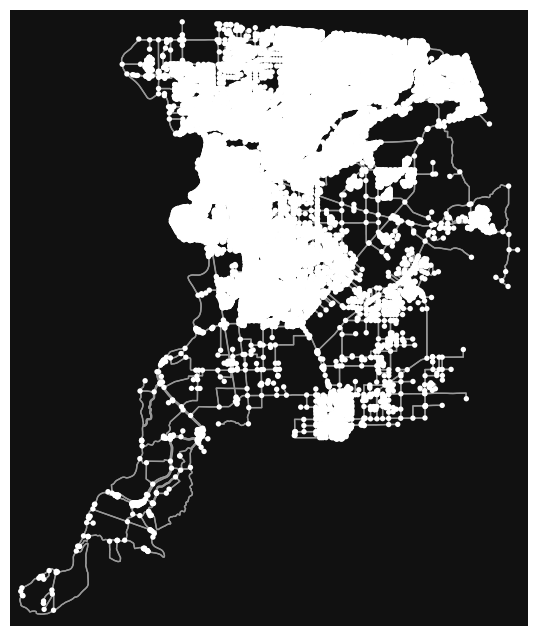

In [29]:
fig, ax = ox.plot_graph(G)

Convert to DFs

In [153]:
nodes, edges = ox.graph_to_gdfs(G)

In [150]:
nodes.to_csv('../data/nodes.csv')
nodes

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
90238621,38.497982,-121.555691,3,NaN,NaN,POINT (-121.55569 38.49798)
90238626,38.497695,-121.557234,1,turning_circle,NaN,POINT (-121.55723 38.49770)
90238634,38.508246,-121.416563,3,NaN,NaN,POINT (-121.41656 38.50825)
90238636,38.508234,-121.413455,4,NaN,NaN,POINT (-121.41345 38.50823)
90238798,38.494981,-121.542607,3,NaN,NaN,POINT (-121.54261 38.49498)
...,...,...,...,...,...,...
12141027826,38.511071,-121.370012,3,NaN,NaN,POINT (-121.37001 38.51107)
12141028171,38.525195,-121.371480,3,NaN,NaN,POINT (-121.37148 38.52519)
12141028178,38.525055,-121.370365,3,NaN,NaN,POINT (-121.37037 38.52506)


In [32]:
nodes['street_count'].value_counts()

3    29600
1    11085
4     7951
2      276
5      195
6       10
Name: street_count, dtype: int64

In [151]:
edges.to_csv('../data/edges.csv')
edges

osmid               name  \
u           v           key                                               
90238621    90433219    0                   10517144          Eider Way   
            90238626    0                   10496672     Dumfries Court   
            90580715    0                   10517144          Eider Way   
90238626    90238621    0                   10496672     Dumfries Court   
90238634    90238636    0                   10496674     Vallecitos Way   
...                                              ...                ...   
12141028178 90557230    0    [775434645, 1311640310]  South Watt Avenue   
12141245483 12141245484 0                 1051262229                NaN   
            90251309    0                 1311666362        Watt Avenue   
12141245484 90251309    0                 1311666363                NaN   
            9660647991  0                 1311666364                NaN   

                                   highway  oneway reversed   length  \
u           v           key                                            
90238621    90433219    0      residential   False    False   80.001   
            90238626    0      residential   False    False  138.515   
            90580715    0      residential   False     True   88.226   
90238626    90238621    0      residential   False     True  138.515   
90238634    90238636    0      residential   False    False  270.437   
...                                    ...     ...      ...      ...   
12141028178 90557230    0          primary    True    False  249.398   
12141245483 12141245484 0           busway    True    False   22.049   
            90251309    0          primary    True    False   35.556   
12141245484 90251309    0    motorway_link    True    False   15.442   
            9660647991  0           busway    True    False   14.141   

                                                                      geometry  \
u           v           key                                                      
90238621    90433219    0    LINESTRING (-121.55569 38.49798, -121.55587 38...   
            90238626    0    LINESTRING (-121.55569 38.49798, -121.55698 38...   
            90580715    0    LINESTRING (-121.55569 38.49798, -121.55558 38...   
90238626    90238621    0    LINESTRING (-121.55723 38.49770, -121.55709 38...   
90238634    90238636    0    LINESTRING (-121.41656 38.50825, -121.41345 38...   
...                                                                        ...   
12141028178 90557230    0    LINESTRING (-121.37037 38.52506, -121.37036 38...   
12141245483 12141245484 0    LINESTRING (-121.38029 38.55979, -121.38012 38...   
            90251309    0    LINESTRING (-121.38029 38.55979, -121.38010 38...   
12141245484 90251309    0    LINESTRING (-121.38012 38.55964, -121.38010 38...   
            9660647991  0    LINESTRING (-121.38012 38.55964, -121.38000 38...   

                              lanes maxspeed bridge  ref junction access  \
u           v           key                                                
90238621    90433219    0       NaN      NaN    NaN  NaN      NaN    NaN   
            90238626    0       NaN      NaN    NaN  NaN      NaN    NaN   
            90580715    0       NaN      NaN    NaN  NaN      NaN    NaN   
90238626    90238621    0       NaN      NaN    NaN  NaN      NaN    NaN   
90238634    90238636    0       NaN      NaN    NaN  NaN      NaN    NaN   
...                             ...      ...    ...  ...      ...    ...   
12141028178 90557230    0    [1, 2]   55 mph    NaN  NaN      NaN    NaN   
12141245483 12141245484 0       NaN      NaN    NaN  NaN      NaN    NaN   
            90251309    0         5   45 mph    NaN  NaN      NaN    NaN   
12141245484 90251309    0         2      NaN    NaN  NaN      NaN    NaN   
            9660647991  0       NaN      NaN    NaN  NaN      NaN    NaN   

                            tunnel  
u           v           key         
9023

## Geocoding with GoogleMaps API to get latitude and longitude to match to closest intersection

In [75]:
api_key = os.environ['GOOGLE_API_KEY']
gmaps = googlemaps.Client(key=api_key)
# addresses = df.loc[df['IsIntersection'] | df['IsExactAddress'], 'GeocodeAddress']
results_df = pd.DataFrame()
for index, row in df.iterrows():
    if row['IsIntersection'] or row['IsExactAddress']:
        address = row['GeocodeAddress']
        result = gmaps.geocode(address)
        result_df = pd.json_normalize(result)
        row_df = df.loc[[index]]
        row_df = pd.concat([row_df] * int(result_df.shape[0])).reset_index(drop=True)
        result_df = pd.concat([row_df, result_df], axis=1)
    else:
        result_df = df.loc[[index]].reset_index(drop=True)
    results_df = pd.concat([results_df, result_df])
results_df.reset_index(drop=True, inplace=True)

In [79]:
results_df

,OBJECTID,CaseNum,DecedentAge,Mode,SubManner,Gender,Race,DeathDate,DeathYear,IncidentPlace,...,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,partial_match,plus_code.compound_code,plus_code.global_code,postcode_localities
0,1,19-00010,29,Driver,Accident (MVA),Male,African American,1/2/2019 12:00:00 AM,2019,Roadway/Highway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,19-00054,57,Driver,Accident (MVA),Male,"White, Italian",1/4/2019 12:00:00 AM,2019,Motor Vehicle,...,-121.080702,ROOFTOP,38.514745,-121.079403,38.512047,-121.082101,NaN,NaN,NaN,NaN
2,3,19-00066,53,Driver,Accident (MVA),Female,"White, Spanish",1/5/2019 12:00:00 AM,2019,Roadway/Highway,...,-121.413773,GEOMETRIC_CENTER,38.511903,-121.412424,38.509206,-121.415122,NaN,NaN,NaN,NaN
3,4,19-00084,58,Driver,Accident (MVA),Male,White,1/6/2019 12:00:00 AM,2019,Roadway/Highway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,19-00197,57,Pedestrian,Accident (MVA),Male,Mexican,1/10/2019 12:00:00 AM,2019,Roadway/Highway,...,-121.355177,GEOMETRIC_CENTER,38.662256,-121.353828,38.659558,-121.356526,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,1261,24-04009,32,Other,Accident (MVA-Criminal),Female,African American,8/30/2024 12:00:00 AM,2024,Parking Lot,...,-121.465866,ROOFTOP,38.571109,-121.464508,38.568411,-121.467206,NaN,NaN,NaN,NaN
1138,1262,24-04019,86,Other,Accident (MVA-Criminal),Female,White,8/30/2024 12:00:00 AM,2024,Sidewalk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1139,1264,24-04082,23,Other,Accident (MVA),Male,White,9/3/2024 12:00:00 AM,2024,Roadway/Highway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1140,1266,24-04117,32,Driver,Accident (MVA),Male,Hispanic,9/5/2024 12:00:00 AM,2024,Motor Vehicle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
def find_closest_node(lat, lon, nodes):
    closest_node = None
    min_distance = float('inf')
    for osmid, node in nodes.iterrows():
        node_lat = node['y']
        node_lon = node['x']
        distance = geodesic((lat, lon), (node_lat, node_lon)).meters
        if distance < min_distance:
            min_distance = distance
            closest_node = osmid
    return closest_node, min_distance

for index, row in results_df.iterrows():
    if isinstance(row['types'], (list, str)) and ('intersection' in row['types'] or 'premise' in row['types']):
        closest_node, min_distance = find_closest_node(row['geometry.location.lat'], row['geometry.location.lng'], nodes)
        results_df.loc[index, 'closest_node'] = closest_node
        results_df.loc[index, 'node_distance'] = min_distance

In [95]:
results_df.to_csv('../data/geocoded_addresses.csv')
results_df

,OBJECTID,CaseNum,DecedentAge,Mode,SubManner,Gender,Race,DeathDate,DeathYear,IncidentPlace,...,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,partial_match,plus_code.compound_code,plus_code.global_code,postcode_localities,closest_node,node_distance
0,1,19-00010,29,Driver,Accident (MVA),Male,African American,1/2/2019 12:00:00 AM,2019,Roadway/Highway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,19-00054,57,Driver,Accident (MVA),Male,"White, Italian",1/4/2019 12:00:00 AM,2019,Motor Vehicle,...,38.514745,-121.079403,38.512047,-121.082101,NaN,NaN,NaN,NaN,9.045171e+07,18.116500
2,3,19-00066,53,Driver,Accident (MVA),Female,"White, Spanish",1/5/2019 12:00:00 AM,2019,Roadway/Highway,...,38.511903,-121.412424,38.509206,-121.415122,NaN,NaN,NaN,NaN,9.069184e+07,1.250697
3,4,19-00084,58,Driver,Accident (MVA),Male,White,1/6/2019 12:00:00 AM,2019,Roadway/Highway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,19-00197,57,Pedestrian,Accident (MVA),Male,Mexican,1/10/2019 12:00:00 AM,2019,Roadway/Highway,...,38.662256,-121.353828,38.659558,-121.356526,NaN,NaN,NaN,NaN,7.779937e+09,2.734753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,1261,24-04009,32,Other,Accident (MVA-Criminal),Female,African American,8/30/2024 12:00:00 AM,2024,Parking Lot,...,38.571109,-121.464508,38.568411,-121.467206,NaN,NaN,NaN,NaN,9.045134e+07,76.610684
1138,1262,24-04019,86,Other,Accident (MVA-Criminal),Female,White,8/30/2024 12:00:00 AM,2024,Sidewalk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1139,1264,24-04082,23,Other,Accident (MVA),Male,White,9/3/2024 12:00:00 AM,2024,Roadway/Highway,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1140,1266,24-04117,32,Driver,Accident (MVA),Male,Hispanic,9/5/2024 12:00:00 AM,2024,Motor Vehicle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
nodes.loc[90253656]

y                                    38.427211
x                                  -121.054391
street_count                                 3
ref                                        NaN
highway                                    NaN
geometry        POINT (-121.054391 38.4272106)
Name: 90253656, dtype: object

In [ ]:
edges.loc[(90475384,)]

/var/folders/s_/ms4snwvs2b59mw5fvp44bvww0000gq/T/ipykernel_93945/949136594.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  edges.loc[(90475384,)]


,,osmid,name,highway,oneway,reversed,length,geometry,lanes,ref,bridge,maxspeed,access,junction,tunnel,width
v,key,,,,,,,,,,,,,,,
5601979787,0,617514001,Trinity River Drive,tertiary,True,False,17.772,"LINESTRING (-121.26655 38.62311, -121.26673 38...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90396300,0,10530944,Gold Express Drive,tertiary,False,False,123.474,"LINESTRING (-121.26655 38.62311, -121.26641 38...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5601979798,0,"[968771980, 51921902]",Sunrise Boulevard,primary,True,False,546.869,"LINESTRING (-121.26655 38.62311, -121.26590 38...","[3, 4]",CR E2,NaN,45 mph,NaN,NaN,NaN,NaN


In [116]:
mapbox_api_key = os.environ['MAPBOX_API_KEY']
latitude = 38.508234
longitude = -121.413455
zoom = 19
width = 640
height = 640
url = f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/{longitude},{latitude},{zoom}/{width}x{height}?access_token={mapbox_api_key}"
response = requests.get(url)

# Save the image if the request was successful
if response.status_code == 200:
    with open('mapbox_satellite_streets_view.jpg', 'wb') as f:
        f.write(response.content)

In [123]:
latitude = 38.427211
longitude = -121.054391
G = ox.graph_from_point((latitude, longitude), dist=100, network_type='drive')

/Users/Ian/projects/traffic-fatalities/venv/lib/python3.8/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


NetworkXPointlessConcept: Connectivity is undefined for the null graph.

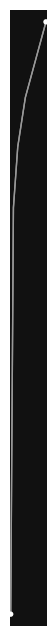

In [ ]:
fig, ax = ox.plot_graph(G)